# <span style="color:green"> ESERCITAZIONE 12 </span>

### <span style="color:blue">  Esercizio 12.2 </span> 
<span style="color:blue"> Modifica l'architettura della rete neurale dell'esercizio precedente introducendo i layer convoluzionali. </span> 

### Filtri di convoluzione

Nell'esericizio precedente abbiamo usato una rete neurale fatta di layer di neuroni. In questo esercizio usiamo una rete neurale **convoluzionale**. Una rete neurale convoluzonale è una rete neurale in cui, o tra un layer e l'altro, o prima di tutti i layer, ci sono dei **filtri** che servono a **sintetizzare l'informazione**. 

Abbiamo visto che l'immagine è fatta di pixel, ciascuno dei quali viene analizzato dai neuroni. Ciascuno di questi tassellini contiene informazioni sulla forma della cifra e sulla gradazione di colore, in questo caso grigio. Per poter riconoscere la cifra nel pixel non è necessario che questo trasporti tutta la sua informazione dal primo all'ultimo layer. E' possibile rendere **più efficiente** il processo **trascurando le informazioni non necessarie e mantenendo quelle fondamentali** per il riconoscimento della cifra: questo è il compito del filtro. 

Questa è l'idea di funzionamento del filtro. Supponiamo che il **pixel sia una matrice** $2n\times 2n$: **lo suddividiamo** in $4$ matrici $n\times n$ e per ciascuno di loro **sintetizziamo l'infomazione**. I due modi più comuni per sintetizzare l'informazione sono: 

1. **max pooling**: di tutti gli elementi della matrice $n\times n$ scelgo il massimo;
2. **average pooling**: calcolo la media aritmetica di tutti gli elementi della matrice $n\times n$.

In questo esercizio useremo il max pooling. Grazie ai filtri è possibile **estrarre le features fondamentali** per il riconoscimento di una cifra, trascurando le infomazioni che non servono. L'informazione sintetizzata viene inviata al layer successivo e lo stesso processo sarà ripetuto fino all'ultimo layer. 

### Modifiche alla rete neurale

Affinché sia possibile costruire una rete neurale convoluzionale, è necessario apportare le seguenti modifiche alla rete neurale dell'esercizio precedente:

1. **Conv2D**: specifica che si tratta di un layer convoluzionale in 2D;
2. **MaxPooling2D**: filtro che esegue l'operazione di max pooling in 2D;
3. **Dropout**: funzione che complica il processo di apprendimento spegnendo a turno e a caso alcuni neuroni, al fine di rendere più robusto il modello;
4. **Flatten**: trasforma una forma 2D in una 1D, in modo da poter usare i layer di neuroni come nei problemi precedenti;
5. **Dense**: tipo di interazione tra i neuroni per cui tutti interagiscono con tutti;
6. **SoftMax**: funzione di attivazione da usare perché, dovendo il neurone comunicare una probabilità fra tante, il suo output deve essere più netto possibile. 

Queste modifiche sono suggerite nel testo dell'esercizio ma questa volta la rete neurale la dobbiamo costruire noi.

### Rete neurale convoluzionale

In [1]:
#Richiamo le librerie.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

2024-06-20 16:29:59.244710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Step 1. Carico il dataset dal mnist.
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# print train and test data shape
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 28, 28)
Y_test shape: (10000,)


In [3]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


In [4]:
print('Prima di to categorical:')
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Prima di to categorical:
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000,)

60000 train samples
10000 test samples


In [5]:
# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [6]:
print('Dopo di to categorical:')
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Dopo di to categorical:
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


In [7]:
#Step 2. Definisco la rete neurale.
from keras.models import Sequential
from keras.layers import Dense, Dropout
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

In [8]:
def create_CDNN():
    #Inizializza il modello.
    model = Sequential() 
    #Definisco la rete neurale convoluzionale 2D. Il primo layer ha 10 filtri.
    #Trattandosi del primo layer, devo dire qual è la funzione di attivazione e la forma dei dati di input.
    model.add(Conv2D(10, kernel_size=(5,5), activation='relu', input_shape=input_shape))   
    #Aggiungo un secondo layer convoluzionale con 90 filtri.
    model.add(Conv2D(90, kernel_size=(5,5), activation='relu'))   
    #Agguingo la funzione Dropout: durante la fase di training si spengono a caso e a turno
    #la metà dei neuroni (0.5), in modo da complicare l'apprendimento. Il modello sarà robusto.
    model.add(Dropout(0.5))
    #Dico che il modo di sintetizzare l'informazione sui filtri è il max pooling.
    model.add(MaxPooling2D(pool_size=(2,2)))
    #Rendo l'informazione di input da 2D a 1D.
    model.add(Flatten())
    #Aggiungo un layer di 25 neuroni.
    model.add(Dense(25, activation='relu'))
    #Aggiungo l'ultimo layer di neuroni, con funzione di attivazione softmax, per le probabilità.
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


In [9]:
#Step 3. Scelgo l'ottimizzatore e la funzione costo e compilo il modello.
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam

def compile_model():
    # create the model
    model=create_CDNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [10]:
#Step 4. Alleno il modello.
#Attenzione: il training di un'epoca dura circa due minuti.
#Per questo scelgo di eseguirlo solo per 10 epoche. 
#Ho provato con 2 epoche e l'accuratezza era del 97%.
#Andava già bene, quindi adesso può fare meglio.

# training parameters
batch_size = 32
epochs = 10

# create the deep neural net
model_CDNN = compile_model()

# train DNN and store training info in history
history = model_CDNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10


2024-06-20 16:31:33.308783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 16:31:33.317502: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1875/1875 [==============================] - 103s 55ms/step - loss: 0.3376 - acc: 0.8992 - val_loss: 0.1650 - val_acc: 0.9679
Epoch 2/10
1875/1875 [==============================] - 99s 53ms/step - loss: 0.1024 - acc: 0.9700 - val_loss: 0.1020 - val_acc: 0.9798
Epoch 3/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0720 - acc: 0.9784 - val_loss: 0.0798 - val_acc: 0.9825
Epoch 4/10
1875/1875 [==============================] - 99s 53ms/step - loss: 0.0591 - acc: 0.9824 - val_loss: 0.0701 - val_acc: 0.9847
Epoch 5/10
1875/1875 [==============================] - 100s 54ms/step - loss: 0.0505 - acc: 0.9845 - val_loss: 0.0594 - val_acc: 0.9863
Epoch 6/10
1875/1875 [==============================] - 98s 52ms/step - loss: 0.0438 - acc: 0.9863 - val_loss: 0.0523 - val_acc: 0.9886
Epoch 7/10
1875/1875 [==============================] - 96s 51ms/step - loss: 0.0383 - acc: 0.9881 - val_loss: 0.0517 - val_acc: 0.9867
Epoch 8/10
1875/1875 [==============================] - 

313/313 [==============================] - 6s 19ms/step - loss: 0.0372 - acc: 0.9894

Test loss: 0.03720518946647644
Test accuracy: 0.9894000291824341


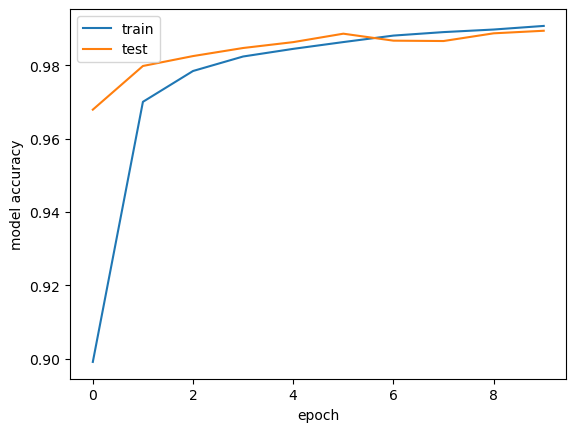

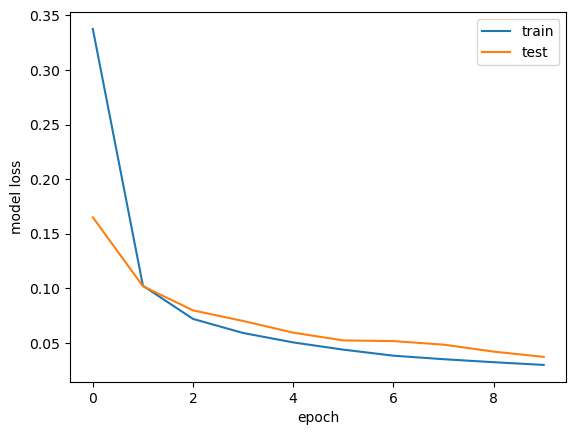

In [11]:
#Step 5. Valuto le performance del modello.
# evaluate model
score = model_CDNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

313/313 [==============================] - 5s 16ms/step


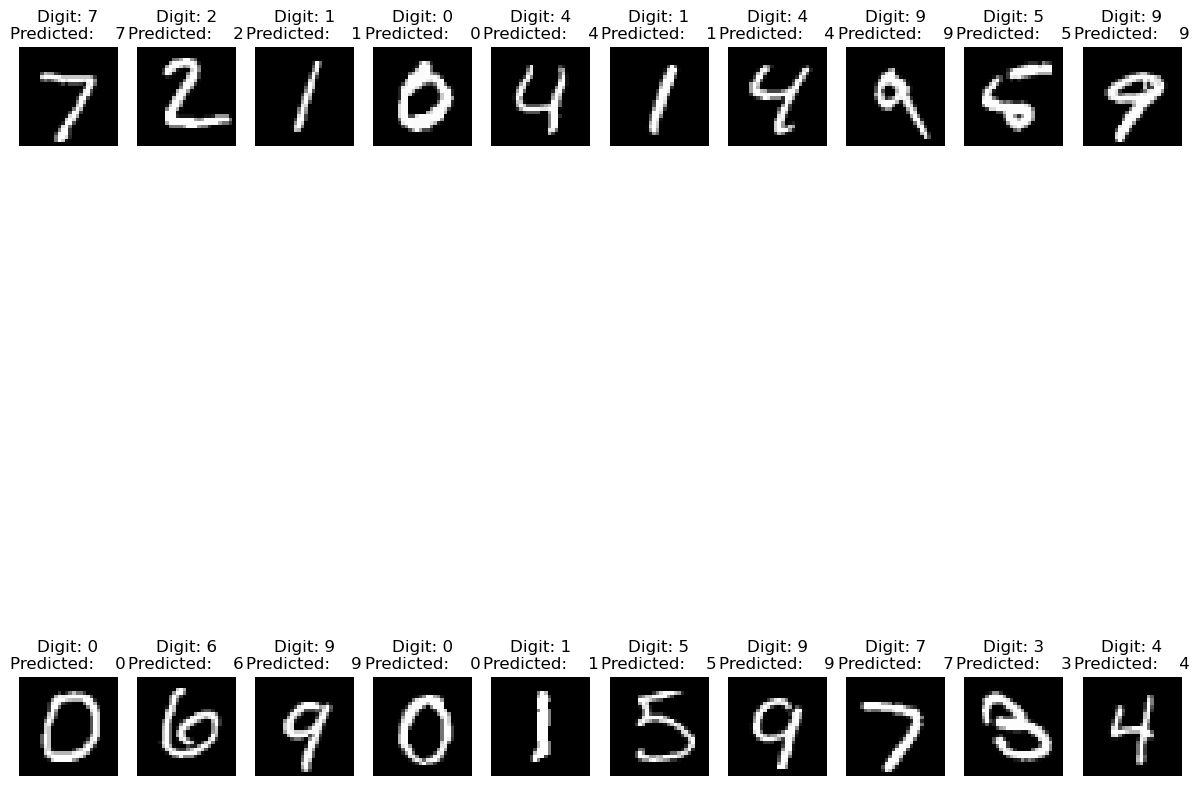

In [15]:
#Step 6. Ora che il modello è pronto, genero nuovi punti applicandolo.
#Le X sono le stesse X di test, le Y sono le etichette che la rete fornirà.
#Questa volta non dico io le Y, ma le deve indovinare lei.
predictions = model_CDNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

plt.figure(figsize=(15, 15)) 
for i in range(20):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Osservazioni

Si ottiene loss $=0.0298$ e accuratezza del $99\%$. Le due coppie di curve di loss e accuratezza per i dati di train e di test si avvicinano sempre più fino ad essere quasi sovrapposte per le ultime epoche. Il modello riconosce tutte le $20$ cifre che gli vengono proposte. Ottimo risultato. 